# Accuracy tracking and update model

This notebook walks through the process of submitting predictions and actuals to MLOps and subsequently, re-building a custom model again to update the model due to drift observed in feature, prediction and accuracy

## Agenda
We'll do the following:
<br/>
1. Submit predictions and actuals 
2. Redraw sample 
3. Rebuild model 
4. Final check

### Imports
First, we need to make the proper imports


In [2]:
# sklearn
import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Datarobot 
import datarobot as dr
from datarobot import Project, Deployment
from datarobot.enums import SERVICE_STAT_METRIC, ACCURACY_METRIC
dr.Client(config_path='config.yaml')

# Others
import sys, os
import pandas as pd
import numpy as np
import pickle
import requests
import json
import time 
import math
from datetime import datetime
import matplotlib

from platform import python_version
print(python_version())
os.getcwd()

3.7.0


'/Users/eu.jin.lok/Documents/GIT-Projects/DataRobot_Workflows/MLOps_certification/development'

In [3]:
with open('Creds.json') as f:
    param = json.load(f)

DATAROBOT_KEY = param['token']
API_KEY = param['key']
USERNAME = param['username']
DEPLOYMENT_ID = '5e003cc8dd923b0579cc93c4'
MAX_PREDICTION_FILE_SIZE_BYTES = 52428800  # 50 MB

deployment = dr.Deployment.get(deployment_id=DEPLOYMENT_ID)

## 1. Submit predictions and actuals

To submit predictions, we'll first need to do a few things. We'll need to configure the association ID and ensure that MLOps knows which column has the unique ID relationship between the predictions and the actuals 

In [13]:
# Custom fuction required to associate the relationship between predictions and actuals 
def set_association_id(deployment_id, association_id, allow_missing_values=False):
    """Assigns the association ID for a deployment"""
    url = f'{BASE_URL}/modelDeployments/{deployment_id}/associationIdSettings/'
    
    data = {'allowMissingValues': allow_missing_values, 'columnName': association_id}
    
    resp = requests.patch(url, json=data, headers=HEADERS)
    resp.raise_for_status()
    return resp.json()

# Assign an association ID to the deployment and set up drift tracking
'''
HEADERS = {
    'Content-Type': 'application/json',
    'Authorization':  f'Token {API_KEY}'
}

association_id_column_name = 'SalesID'
BASE_URL = 'https://app.datarobot.com/api/v2'

set_association_id(deployment.id, association_id_column_name, allow_missing_values=False)
'''

After setting up the association ID, we need to make predictions via API, and we'll need the python code in MLOps. we can get this from our deployments tab, and under the 'Integrations' tab. We'll save the script and store it somewhere, we'll be invoking it soon.

We're going to use the X_test data that we saved before and draw random records from it. We'll do this for the next 5 days leading up to the 27th Dec 2019. Now because we're drawing random records every day, we need to create a new unique ID or else we will be re-submitting previously used records. 

In [ ]:
# read data 
X_test = pd.read_csv(os.getcwd() + '/dataset/X_test.csv', low_memory=False) # low_memory must be added to avoid error
y_test = pd.read_csv(os.getcwd() + '/dataset/Y_test.csv', low_memory=False) # low_memory must be added to avoid error
XY_test = pd.concat([X_test, y_test],axis=1)

# Draw a sequence of records 
scoring = XY_test.sample(n=2000, replace=False)

# Fabricate a different UniqueID so if we drew the same records it won't be an issue
scoring.SalesID = scoring.SalesID + int(datetime.now().strftime('%Y%m%d%H%M'))*100000

# Save to csv
scoring.to_csv(os.getcwd() + "/dataset/scoring.csv",index=False, header = True)
scoring.head()

So to make a submission to MLOps, go to where the script was saved earlier. Run on command line (make sure env activated) on the folder where the script is saved, in this case i've called it 'scoring.py', and specify the path to the dataset:
```bash
python scoring.py "dataset/scoring.csv"
```

Seperately, we'll need to submit the actuals as well. For the actuals, we'll use the GUI but via the AI Catalog upload.

In [89]:
# Prep the actuals data format correctly. 
actuals = scoring[['SalesID','SalePrice']]
actuals['was_acted_on'] = 'False'
actuals.columns = ['association_id','actual_value','was_acted_on']  # IMPORTANT: Must comply to these names! 
actuals.association_id = actuals.association_id.astype(str)
actuals.actual_value = actuals.actual_value.astype(float)

# Save actuals 
actuals.to_csv(os.getcwd() + "/dataset/actuals.csv",index=False, header = True)
actuals.head()

##  2. Redraw sample 
The day is 27th Dec 2019, 4 days after the first submissions to MLOps, we've build up about 4 days worth of data. There's a slight data drift but the accuracy and prediction drift looks fine. 

We will now draw records for submissions from the original dataset that has models made after the year 2000. This will showcase a strong datadrift and hopefully, a huge drift in predictions and accuracy should be observed. 

In [5]:
# read data 
df = pd.read_csv(os.getcwd() + '/dataset/fast iron 100k data.csv', low_memory=False) # low_memory must be added to avoid error

# subset the data 
df = df.iloc[:,0:19]
df.drop(columns=['fiProductClassDesc'],inplace=True)

# munge 
for i in df.columns:
    if df[i].dtypes == 'int64':
        df[i].fillna(0, inplace=True)
    elif df[i].dtypes == 'float64':
        df[i].fillna(0, inplace=True)
    else:
        df[i].fillna('UNK', inplace=True)

# pop out the target on its own
y = df.pop('SalePrice')

# Split training and test and save them 
X_train, X_test, y_train, y_test = train_test_split(df, y, train_size = 70000, random_state = 42) # up the traing size
X_test.to_csv(os.getcwd() + "/dataset/X_test_new.csv",index=False, header = True)
y_test.to_csv(os.getcwd() + "/dataset/Y_test_new.csv",index=False, header = True)

# From training set split futher to get validation set and save them 
X_train.pop('SalesID')
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size = 0.9, random_state = 42)
X_train.to_csv(os.getcwd() + "/dataset/X_train_new.csv",index=False, header = True)
y_train.to_csv(os.getcwd() + "/dataset/Y_train_new.csv",index=False, header = True)

print(X_train.shape)
print(X_test.shape)

(63000, 16)
(30000, 17)


we'll submit this new dataset for scoring and we should see a drift in the feature, predictions and hopefully accuracy. And as usual, we'll need to submit both the test data and the actuals

This set of data however, will be used twice. First on the old model, and secondly on the new model. Because we are using this same dataset, we are comparing apples with apples between old and new model. This builds up a strong demonstration for the model updating. 

In [16]:
# read data 
X_test = pd.read_csv(os.getcwd() + '/dataset/X_test_new.csv', low_memory=False) # low_memory must be added to avoid error
y_test = pd.read_csv(os.getcwd() + '/dataset/Y_test_new.csv', low_memory=False) # low_memory must be added to avoid error
XY_test = pd.concat([X_test, y_test],axis=1)

# Draw a sequence of records 
scoring = XY_test.sample(n=2000, replace=False)

# Fabricate a different UniqueID so if we drew the same records it won't be an issue
scoring.SalesID = scoring.SalesID + int(datetime.now().strftime('%Y%m%d%H%M'))*100000

# Save to csv
scoring.to_csv(os.getcwd() + "/dataset/scoring_final.csv",index=False, header = True)
scoring.head()

# Prep the actuals data format correctly. 
actuals = scoring[['SalesID','SalePrice']]
actuals['was_acted_on'] = 'False'
actuals.columns = ['association_id','actual_value','was_acted_on']  # IMPORTANT: Must comply to these names! 
actuals.association_id = actuals.association_id.astype(str)
actuals.actual_value = actuals.actual_value.astype(float)

# Save actuals 
actuals.to_csv(os.getcwd() + "/dataset/actuals_final.csv",index=False, header = True)
actuals.head()

/Users/eu.jin.lok/Documents/GIT-Projects/data-science-scripts/eujinlok/MLOps-Demo-Certification/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/eu.jin.lok/Documents/GIT-Projects/data-science-scripts/eujinlok/MLOps-Demo-Certification/myenv/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,association_id,actual_value,was_acted_on
59479,20191227113463644,19500.0,False
9729,20191227113478204,27000.0,False
61355,20191227113481086,16500.0,False
67519,20191227113543560,33000.0,False
43482,20191227113485196,23500.0,False


When the 'scoring_final.csv' and the 'actuals_final.csv' files were submitted to MLOps, we observed a huge Feature drift. Prediction and accuracy drift hasn't changed much due to the fact that YearMade isn't a really predictive feature which is slighlty unfortunately. But none the less, feature drift is enough of a strong case 


## 3. Rebuild model
Now that we have demonstrated a huge drift, we'll go and build ourselves a new model and replace it. Lets copy the same process, which is the pipeline that we used previously. 

In [6]:
# Split the feature types   
numeric_features = list(X_train.select_dtypes(include=np.number).columns.values)
categorical_features = list(set(X_train.columns) - set(numeric_features))

# Create pipeline for numericals 
numeric_preprocessing = Pipeline(
    [('Imputation', SimpleImputer(strategy='mean')), ('Scaling', StandardScaler())]
)

# Create pipeline for categorical 
categorical_preprocessing = Pipeline(
    [
        ('Imputation', SimpleImputer(strategy='constant', fill_value='UNK')),
        ('One Hot Encoding', OneHotEncoder(handle_unknown='ignore')),
    ]
)

# Build in the transformer 
preprocessing = make_column_transformer(
    (numeric_preprocessing, numeric_features),
    (categorical_preprocessing, categorical_features),
)

# Chain the pipelines 
pipeline = Pipeline(
    [('Preprocessing', preprocessing), ('Random Forest Regressor', RandomForestRegressor())]
)

# Now fit it to the training data 
pipeline.fit(X_train, y_train)

/Users/eu.jin.lok/Documents/GIT-Projects/data-science-scripts/eujinlok/MLOps-Demo-Certification/myenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('Preprocessing',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('Imputation',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                                    

### Evaluate

To make sure we're doing things right, lets run through a quick evaluation check. We should still hit around the same mark which is the 11k RMSE 

RMSE = 10468.168277245752


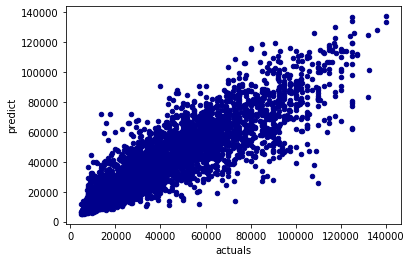

In [8]:
# predict test instances
y_preds = pipeline.predict(X_valid)
y_preds = pd.concat([y_valid.reset_index(drop=True),pd.DataFrame(y_preds)],axis=1)
y_preds.columns = ['actuals','predict']

# RMSE
print('RMSE = ' + str(math.sqrt(mean_squared_error(y_preds.actuals,y_preds.predict))))

# Plot 
ax1 = y_preds.plot.scatter(x='actuals',
                       y='predict',
                       c='DarkBlue')

Great so its consistent, now let's reupload this new model to MLOps. We'll need to pickle this new pipeline as well and TAR it like before. Make sure to follow the same process as before or else we need to modify that .sh file again.

In [9]:
# Pickle the pipeline
with open('custom_model.pickle', 'wb') as picklefile:
    pickle.dump(pipeline, picklefile)
    
# Save the train dataset with the target for MLOps
df = pd.concat([X_train, pd.DataFrame(y_train)], axis=1, sort=False)
df.to_csv(os.getcwd() + "/dataset/XY_train_final.csv",index=False, header = True)

## 4. Final check

Now as a final check we will resubmit the same tar.gz file to MLOps. Note that previous deployment will not be replaced. Rather we replace it with a new model that we just uploaded. To do this the steps are: 

1. Select the current deployment that we are working on, and select the custom model embedded link
2. Here, add a new model version (in tar.gz format) and test the deployment using the new dataset 
3. If test passed, DON'T click ADD Deployment. Instead...
6. We need to change the learning data that is under 'Model Info' tab
4. When finished, go back to deployments, select the 'burger' menu for the current deployment that we are using...
5. and select replace model and we should be able to see the correct combination. Select that and we're done

Now the deployment has a new model. We need to re-submit the predictions again 
```bash
python scoring.py "dataset/scoring_final.csv"
```

We don't need to alter anything in the script as the deployment hasn't changed. Also note that because we've previously submitted this file, MLOps will automaticaly detect the actuals csv file as well which we submitted earlier on. So, we should now be able to observe that: 

1. Feature drift fixed 
We no longer see the YearMade going off track. Thou we seem to be observing a huge drift problem with fiModelDescription which seems to be a bug? fiBaseModel seems to have also increased in drift despite detecting more new levels from the increased dataset. 

2. Accuracy improvement  
So overall our accuracy has improved quite a fair bit from 11k down to 7k. 
